# Calulate NEUC transport in INALT20 and observation along 23$^{\circ}$W

For both, model and observations we calculate the central position $ Y_{CM} $ and along-pathway intensity $ INT $ of zonal currents using the algorithm of Hsin (2012). 

\begin{equation}
Y_{CM}(x,t) = \frac{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} y\ u(x,y,z,t)\ dy\ dz}{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} u(x,y,z,t)\ dy\ dz}
\label{equ_Y_CM}
\end{equation}

\begin{equation}
INT(x,t) = \int_{Z_l}^{Z_u} \int_{Y_{CM}-W}^{Y_{CM}+W} u(x,y,z,t)\ dy\ dz 
\label{equ_INT}
\end{equation}


where $y$ is latitude, $x$ is longitude, $u$ is zonal velocity, $z$ is depth, $t$ is time, $Z_u$ ($Z_l$) is upper (lower) boundary of the flow, $Y_N$ ($Y_S$) is northern (southern) limit of the flow, and $W$ is the half mean width of the flow.

![](../figures/INALT20_obs_23w_comparison/1_INALT20_obs_23w_1999_2012.png)

For transport calculation of the EUC Brandt et al. (2014) used the following boundary conditions:

$Z_u = 30\,$m, $Z_l = 300\,$m, $Y_N = 1.2^{\circ}$N, $Y_S = 1.2^{\circ}$S

To be consistent with the mooring reconstructed transport of Brandt et al (2014), I will first use $Y_N = 1.2^{\circ}$N, $Y_S = 1.2^{\circ}$S as meridional boundaries for the transport calculations. That will be compared to calculations with a variable meridional boundary. Based on the 23$^{\circ}$W section, I choose $W = 2^{\circ}$.

The depth of the EUC core $Z_{CM}$ will be estimated similar to $Y_{CM}$:

\begin{equation}
Z_{CM}(x,t) = \frac{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} z\ u(x,y,z,t)\ dy\ dz}{\int_{Z_l}^{Z_u} \int_{Y_{S}}^{Y_{N}} u(x,y,z,t)\ dy\ dz}
\label{equ_Z_CM}
\end{equation}

Think about variable depth boundaries. Or boundaries define by density. Because is the model we calculate the EUC transport along the equator, not only at 23W.

- [ ] literature review about depth of EUC in western and eastern basin.


## Tech preample

In [1]:
%matplotlib inline
import os
import dask
import cmocean
import datetime
import nc_time_axis
import cftime
import time
import gsw
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from pathlib import Path
from scipy.io import loadmat
import xscale.signal.fitting as xfit
import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum

## Dask jobqueue and client
To controle the resources used for parallel computations on computing nodes.

In [2]:
import dask_jobqueue
cluster = dask_jobqueue.SLURMCluster(
    # Dask worker size
    cores=4, memory='24GB',
    processes=1, # Dask workers per job
    # SLURM job script things
    queue='cluster', walltime='01:30:00',
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',
    log_directory='./slurm_logs'
)

/gxfs_home/geomar/smomw294/miniconda3/envs/py3_xscale/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34211 instead
  http_address["port"], self.http_server.port


In [3]:
from dask.distributed import Client

In [4]:
client = Client(cluster)
# client = Client(n_workers=1, threads_per_worker=8, memory_limit=12e9)
client

Client Scheduler: tcp://172.18.4.13:42831 Dashboard: http://172.18.4.13:34211/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
cluster.adapt(
    minimum=1, maximum=20,
)

## Output parameters

In [6]:
script_name = 'INALT20_EUC_calc_transport_23W_JRA_test'
out_dir_data = Path('../data/'+script_name+'/')
Path(out_dir_data).mkdir(parents=True, exist_ok=True)
out_data_1 = 'INALT20_EUC_transport'

out_dir_fig = Path('../figures/'+script_name+'/')
Path(out_dir_fig).mkdir(parents=True, exist_ok=True)
out_fig_1 = 'INALT20_'
fig_format = '.png'

savefig = 1; #set one if figures should be saved

## Input parameters
For INALT20 

In [7]:
run_calc_JRA = 0 #set 1 if annual mean should be recalculated
run_calc_CORE = 0 #set 1 if annual mean should be recalculated
global_data_path = Path("/sfs/fs1/work-geomar1/smomw044/")
JRA_path = "INALT20.L46-KFS10X"
exp_id = "INALT20.L46-KFS10?"

CORE_path = "shared/INALT20.L46-KFS044-S"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

restr_years1 = "20[0-1][0-9]"  # restricts to 2010 and 2011

# chunk sizes
chu_x = 40 # None means take the full dataset
chu_y = 100
chu_z = 9
chu_t = 1

# variables wanted
vars_want = ['vosaline','votemper','vozocrtx']

Calculation of EUC - Boundary conditions

In [8]:
lonlim = [-24, -22]
latlim = [-4.0, 4]
zlim = [0, 300]

## integers
xclim1 = 590+319
xclim2 = 590+360 # one more to right which will be drop (interp T on u grid)
yclim1 = 1569-20
yclim2 = 1680+10+20

# for nc-file attrs
lat_s = latlim[0]
lat_n = latlim[1]
lon_e = lonlim[0]
lon_w = lonlim[1]

p_ref = 0 # dbar; reference pressure for potential density calculation
W = 2 #degN,  half mean width of the flow
sigma_lim = [0,26.8] #kg/m^3, vertical boundaries of flow for INT [Z_u, Z_l]

Find relevant data files for INALT20

## Functions

### Potential density

In [9]:
def calc_pdens_sw(p_ref,ds):
    """ Calculates potential density from practical salinity and potential density using the TEOS-10 seawater library
    Parameters
    ----------
    pref : int
    reference pressure for potential density calculation
    SP : xr.DataArray
    Data array of practical salinity [psu], same dimension as pt
    pt : xr.DataArray
    Data array of potential temperature [degree_C], same dimension as SP
    Returns
    -------
    xr.DataArray
    Data array of potential density calculated using the TEOS-10 seawater library [kg/m^3], same dimension as input data arrays
    """
    # calculate pressure from depth (z, pos. upward): gsw.p_from_z(z,lat)
    p = xr.apply_ufunc(
    gsw.p_from_z,
    -abs(ds.deptht),ds.gphit,
    dask='parallelized', output_dtypes=[float, ]
    )
    
    # calculate absolute sal (SA) from pract. sal (SP): gsw.SA_from_SP(SP,p,lon,lat)
    SA = xr.apply_ufunc(
    gsw.SA_from_SP,
    ds.vosaline,p,ds.glamt,ds.gphit,
    dask='parallelized', output_dtypes=[float, ]
    )
    
    # calculate cons temp (CT) from pot temp (pt): gsw.CT_from_pt(SA,pt)
    CT = xr.apply_ufunc(
    gsw.CT_from_pt,
    SA,ds.votemper,
    dask='parallelized', output_dtypes=[float, ]
    )
    
    #calculate in-situ temp (t) from cons temp: gsw.t_from_CT(SA, CT, p)
    t = xr.apply_ufunc(
    gsw.t_from_CT,
    SA, CT, p,
    dask='parallelized', output_dtypes=[float, ]
    )
    
    #calcualte potential density of seawater: gsw.pot_rho_t_exact(SA,t,p,p_ref)
    pdens = xr.apply_ufunc(
    gsw.pot_rho_t_exact,
    SA, t, p,p_ref,
    dask='parallelized', output_dtypes=[float, ]
    )-1000
    pdens.name='sigma_%sm' %p_ref
    pdens.attrs['units']='kg/m^3'
    pdens.attrs['long_name']='Potential density'
    pdens.attrs['reference_pressure']= '%s dbar' %p_ref
    
    return pdens

### Eastward transport

In [10]:
def eastw_transport(ucur,dy,dz,z_dim,y_dim):
    ucur = ucur.where(ucur>=0)
    trs_e = (dy*(ucur*dz).sum(dim=z_dim)).sum(dim=y_dim,skipna=True)*1e-6
    
    trs_e.attrs['units']='Sv'
    trs_e.attrs['long_name']='Eastward transport'
    return trs_e

### Y$_{CM}$ (central position of a current)

In [11]:
def YCM(ucur,lat,dy,dz,z_dim,y_dim):
    ucur = ucur.where(ucur>=0)
    y_cm = (dy*(lat*ucur*dz).sum(dim=z_dim)).sum(dim=y_dim,skipna=True)/(
            dy*(ucur*dz).sum(dim=z_dim)).sum(dim=y_dim,skipna=True)
    
    y_cm.attrs['units']='degN'
    y_cm.attrs['name']='Y_CM'
    y_cm.attrs['long_name'] = 'Central latitude'
    return y_cm

### Z$_{CM}$ (core depth of a current)

In [12]:
def ZCM(ucur,z,dy,dz,z_dim,y_dim):
    ucur = ucur.where(ucur>=0)
    z_cm = (dy*(z*ucur*dz).sum(dim=z_dim)).sum(dim=y_dim,skipna=True)/(
            dy*(ucur*dz).sum(dim=z_dim)).sum(dim=y_dim,skipna=True)
    
    z_cm.attrs['units']='m'
    z_cm.attrs['name']='Z_CM'
    z_cm.attrs['long_name'] = 'Central depth'
    return z_cm

### INT (eastward transport using cor following algorithm of Hsin 2012)

In [13]:
def eastw_INT(ucur,sigma,Y_CM,depth,lat,dy,dz,sigma_lim,W,z_dim,y_dim):
    ucur = ucur.where(((ucur>0)&
                      (sigma_lim[0]<=sigma)&
                      (sigma<=sigma_lim[1])&
                      (Y_CM-W < lat)&
                      (Y_CM+W > lat)))
    INT_e = (dy*(ucur*dz).sum(dim=z_dim)).sum(dim=y_dim,skipna=True)*1e-6
    
    INT_e.attrs['units']='Sv'
    INT_e.attrs['name']='INT'
    INT_e.attrs['long_name']='Eastward along-pathway intensity'
    INT_e.attrs['history']='Eastward along-pathway intensity'
    return INT_e

### Harmonic fit function Willy

In [14]:
def harmonic_cycle(t, T=1, phi=0):
    """Create harmonic cycles."""
    return np.sin(2 * np.pi / T * (t + phi))

def normalize(x=None, y=None):
    return y / np.linalg.norm(y) / (x.max() - x.min()) ** 0.5

def harmonic_proj(t=None, T=None, dt=None, signal=None, dims='time'):
    #     harmonic_mode = (
    #         normalize(t, harmonic_cycle(t, T=T, phi=0))
    #         + 1j * normalize(t, harmonic_cycle(t, T=T, phi=T / 4.0))
    #     ) / (2 ** 0.5)
    harmonic_mode = normalize(
        t,
        harmonic_cycle(t, T=T, phi=0) + 1j * harmonic_cycle(t, T=T, phi=T / 4.0)
    )
    return (signal * xr.DataArray(harmonic_mode, dims=dims)* dt**0.5).sum(dims)

def harmonic_phase(t=None, T=None, dt=None, signal=None, dims='time'):
    proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal, dims=dims)
    phi = np.arctan2(np.imag(proj), np.real(proj)) * T / np.pi / 2
    phi.attrs['name'] = 'Phase'
    phi.attrs['units'] = 'days'
    return phi

def harmonic_amplitude(t=None, T=None, dt=None, signal=None, dims='time'):
    proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal, dims=dims)
    return 2 * np.abs(proj)

def harm_fit(s_n,dims='time'):
    time_ordinal = np.array([pd.to_datetime(x).toordinal() for x in s_n[dims].values])
    time_ordinal -= time_ordinal[0]
    s_n.coords['time_ordinal']=([dims],time_ordinal)
    dt = time_ordinal[1]-time_ordinal[0]

    ah_pha = harmonic_phase(s_n.time_ordinal, 365,dt, s_n, dims=dims)
    ah_amp = harmonic_amplitude(s_n.time_ordinal, 365,dt, s_n, dims=dims)
    sh_pha = harmonic_phase(time_ordinal, 365 / 2.0,dt, s_n, dims=dims)
    sh_amp = harmonic_amplitude(time_ordinal, 365 / 2.0,dt, s_n, dims=dims)
    return xr.merge((ah_pha.rename('ah_pha'), ah_amp.rename('ah_amp'), sh_pha.rename('sh_pha'), sh_amp.rename('sh_amp')))

def reconstr_ts(harmo_JRA_obs,time,T,dims='time'):
    t = np.array([pd.to_datetime(x).toordinal() for x in time])
    t -= t[0]
    t=xr.DataArray(data=t,dims=dims)
    if T==365:
        amp,phi = harmo_JRA_obs.ah_amp,harmo_JRA_obs.ah_pha
    elif T==365/2:
        amp,phi = harmo_JRA_obs.sh_amp,harmo_JRA_obs.sh_pha
    
    JRA_rec = amp * harmonic_cycle(
        t, T=T, phi=phi)
    JRA_rec.coords[dims]=time
    return JRA_rec

### Harmonic fit function xscale

In [15]:
def sinfit_kb(array, periods, dim=None, coord=None, unit='s'):
    #     """
    #     Least squares sinusoidal fit.
    #     Fit sinusoidal functions ``y = A[p] * sin(2 * pi * ax * f[1] + phi[1])``
    #     Parameters
    #     ----------
    #     array : xarray.DataArray
    #         Data to be fitted
    #     periods: float or list of float
    #         The periods of the sinusoidal functions to be fitted
    #     dim : str, optional
    #         The dimension along which the data will be fitted. If not precised,
    #         the first dimension will be used
    #     unit : {'D', 'h', 'm', 's', 'ms', 'us', 'ns'}, optional
    #         If the fit uses a datetime dimension, the unit of the period may be
    #         specified here.
    #     Returns
    #     -------
    #     modes : Dataset
    #     A Dataset with the amplitude and the phase for each periods
    #     """
    import dask.array as da
   
    dim = array.dims[0]
    n = 2 * len(periods) + 1
    # # Sort frequencies in ascending order
    periods.sort(reverse=True)
    # # Re-order the array to place the fitting dimension as the first dimension
    # # + stack the other dimensions
    array_stacked = array
    
    # # Check if the dimension is associated with a numpy.datetime
    # # and normalize to use periods and time in seconds
    # if coord is None:
    coord = array[dim]
    t = coord.data.astype('f8') * 1e-9
    freqs = 1. / pd.to_timedelta(periods, unit=unit).total_seconds()
 
    # # Build coefficient matrix for the fit using the exponential form
    x = da.vstack([da.cos(2 * np.pi * f * t) for f in reversed(freqs)] +
                  [da.ones(len(t), chunks=73), ] +
                  [da.sin(2 * np.pi * f * t) for f in freqs]).T
    x = x.rechunk((73, n))
    
    # # Solve the least-square system
    c, _, _, _ = da.linalg.lstsq(x, array_stacked.data)
    
    # Get cosine (a) and sine (b) ampitudes
    b = c[0:n//2, ][::-1]
    a = c[n//2 + 1:, ]
    
    # # Compute amplitude and phase
    amplitude = da.sqrt(a ** 2 + b ** 2)
    phase = da.arctan2(b, a) * 180. / np.pi
    
    # Store the results
    new_dims = ('periods',) + array_stacked.dims[1:]
    new_coords = {co: array_stacked.coords[co] for co in array_stacked.coords
                  if co != dim}
    var_dict = {'amplitude': (new_dims, amplitude),
                'phase': (new_dims, phase),
                'offset': (array_stacked.dims[1:], c[n//2, ])}
    ds = xr.Dataset(var_dict, coords=new_coords)
    ds = ds.assign_coords(periods=periods)
    ds['periods'].attrs['units'] = unit
    # Unstack the data
    modes = ds
    return modes

def calc_AH_SAH_model(ds_JRA,JRA_cyc):
    JRA_fit2w = sinfit_kb(ds_JRA,
                    dim='time_counter', periods=[182.5,365], unit='D')
    JRA_AH_SAH_CYC = xfit.sinval(JRA_fit2w, JRA_cyc.dayofyear)
    JRA_SAH_CYC = xfit.sinval(JRA_fit2w.sel(periods=[182.5,]),JRA_cyc.dayofyear)
    JRA_AH_CYC = xfit.sinval(JRA_fit2w.sel(periods=[365,]), JRA_cyc.dayofyear)
    return JRA_AH_SAH_CYC, JRA_SAH_CYC, JRA_AH_CYC
def calc_AH_SAH_obs(moor,moor_cyc):
    moor_fit2w = sinfit_kb(moor, periods=[182.5,365], unit='D')
    moor_AH_SAH_CYC = xfit.sinval(moor_fit2w, moor_cyc.dayofyear)
    moor_SAH_CYC = xfit.sinval(moor_fit2w.sel(periods=[182.5,]),moor_cyc.dayofyear)
    moor_AH_CYC = xfit.sinval(moor_fit2w.sel(periods=[365,]), moor_cyc.dayofyear)
    return moor_AH_SAH_CYC, moor_SAH_CYC, moor_AH_CYC

In [16]:
aux_files = list(sorted(
        (global_data_path/ JRA_path).glob(f"{nest_prefix}[m,n]*.nc")
    ))

aux_files

with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                    "y":chu_y,"x":chu_x})

In [17]:
# lonlim = [-24, -22]
# latlim = [-4.0, 4]
# zlim = [0, 300]

# ## integers
# xclim1 = 590+319
# xclim2 = 590+360 # one more to right which will be drop (interp T on u grid)
# yclim1 = 1569
# yclim2 = 1679+10

# ds_mesh.gphit.sel(x=600,y=slice(yclim1,yclim2)).squeeze().values
# ds_mesh.glamt.sel(y=1700,x=slice(xclim1,xclim2)).squeeze().values

## Run calculations

In [18]:
%%time
if run_calc_JRA:
    
    for restr_years in range(2015,2019):
        print (restr_years)
        # JRA
        JRA_files = list(sorted(
            (global_data_path / JRA_path ).glob(
                f"{nest_prefix}{exp_id}{temp_res}{restr_years}????_{restr_years}????_grid_[T,U].nc")
        ))

        ##load JRA output
        with dask.config.set(scheduler='synchronous'):
            ds_JRA_T = xr.open_dataset(
                JRA_files[0],
                chunks={"time_counter":chu_t,
                                 "deptht":chu_z, 
                                 "y":chu_y, 
                                 "x":chu_x},
                decode_cf=True,
                )
        ds_JRA_T = ds_JRA_T.get(['vosaline','votemper'])

        with dask.config.set(scheduler='synchronous'):
            ds_JRA_U = xr.open_dataset(
            JRA_files[1],
            decode_cf=True,
            chunks={"time_counter":chu_t,
                             "depthu":chu_z, 
                             "y":chu_y, 
                             "x":chu_x})


        ## select region JRA
        ds_JRA_T = ds_JRA_T.assign_coords(gphit=(['y','x'],ds_mesh.gphit.squeeze()))
        ds_JRA_T = ds_JRA_T.assign_coords(glamt=(['y','x'],ds_mesh.glamt.squeeze()))
        ds_JRA_T = ds_JRA_T.drop(['nav_lat','nav_lon'])

        ds_JRA_U = ds_JRA_U.assign_coords(gphiu=(['y','x'],ds_mesh.gphiu.squeeze()))
        ds_JRA_U = ds_JRA_U.assign_coords(glamu=(['y','x'],ds_mesh.glamu.squeeze()))
        ds_JRA_U = ds_JRA_U.drop(['nav_lat','nav_lon'])
        
        ds_JRA_U['e1u'] = (('y', 'x'), ds_mesh.e1u.squeeze())
        ds_JRA_U['e2u'] = (('y', 'x'), ds_mesh.e2u.squeeze())
        ds_JRA_U['e3u'] = (('depthu','y', 'x'), ds_mesh.e3u_0.squeeze())
       

        ds_JRA_T = ds_JRA_T.sel(deptht=slice(0,zlim[1]),
                               x=slice(xclim1,xclim2),
                               y=slice(yclim1,yclim2))

        ds_JRA_U = ds_JRA_U.sel(depthu=slice(0,zlim[1]),
                               x=slice(xclim1,xclim2),
                               y=slice(yclim1,yclim2))
        ds_JRA_U = ds_JRA_U.isel(x=slice(0,-1)
                        ).swap_dims({'depthu':'depth'}
                        ).rename({'depthu':'depth'})

        # calculate density
        pdens_JRA = calc_pdens_sw(p_ref,ds_JRA_T)
        
        with xr.set_options(keep_attrs=True):
            # average on U-Grid
            pdens_JRA =(pdens_JRA.isel(x=slice(None,-1))+pdens_JRA.isel(x=slice(1,None)))/2
            # merge to one dataset
            box_JRA = xr.merge([ds_JRA_U.vozocrtx,
                        ds_JRA_U.e1u,
                        ds_JRA_U.e2u,
                        ds_JRA_U.e3u,
                        pdens_JRA.swap_dims({'deptht':'depth'}
                        ).rename({'deptht':'depth'})]).compute()

        # set coordinates and attributes
        lon = box_JRA.glamu.isel(y=5)
        box_JRA = box_JRA.assign_coords(lon=('x',lon))
        lat = box_JRA.gphit.isel(x=20)
        box_JRA = box_JRA.assign_coords(lat=('y',lat))
        box_JRA = box_JRA.swap_dims({'x':'lon','y':'lat'}
                         ).drop({'gphiu','gphit','glamu','time_centered'})
        box_JRA.lat.attrs['units']='degN'
        box_JRA.lat.attrs['long_name']='Latitude'
        box_JRA.lon.attrs['units']='degE'
        box_JRA.lon.attrs['long_name']='Longitude'
        box_JRA.depth.attrs['units']='m'
        box_JRA.depth.attrs['long_name']='Depth'

        ## actual calulations
        ds = box_JRA.sel(lat=slice(-1.2,1.2), depth=slice(30,300))
        Y_CM = YCM(ds.vozocrtx,ds.lat,ds.e2u,ds.e3u,
                   'depth','lat').compute()
        Y_CM.attrs['lat_lim'] = '1.2degS to 1.2degN'
        Y_CM.attrs['depth_lim'] = '30m to 300m'
        Z_CM = ZCM(ds.vozocrtx,ds.depth,ds.e2u,ds.e3u,
                   'depth','lat')
        Z_CM.attrs['lat_lim'] = '1.2degS to 1.2degN'
        Z_CM.attrs['depth_lim'] = '30m to 300m'
        
        T_30 = eastw_transport(ds.vozocrtx,ds.e2u,ds.e3u,
                                  'depth','lat')
        T_30.attrs['lat_lim'] = '1.2degS to 1.2degN'
        T_30.attrs['depth_lim'] = '30m to 300m'
        
        W=2
        INT = eastw_INT(box_JRA.vozocrtx,box_JRA.sigma_0m,Y_CM,ds.depth,box_JRA.lat,
                  box_JRA.e2u,box_JRA.e3u,[0,26.8],W,'depth','lat').compute()
        INT.attrs['lat_lim'] = 'Y_CM-W (min 4degS) to Y_CM+W (max 4degN)'
        INT.attrs['W_name'] = 'Half mean width of flow'
        INT.attrs['W_unit'] = 'degN'
        INT.attrs['W'] = W
        INT.attrs['depth_lim'] = 'Z_u to Z_l (pot dens)'
        INT.attrs['Z_u'] = sigma_lim[0]
        INT.attrs['Z_u_name'] = 'Upper boundary of flow'
        INT.attrs['Z_u_unit'] = 'kg/m^3'
        INT.attrs['Z_l'] = sigma_lim[1]
        INT.attrs['Z_l_name'] = 'Lower boundary of flow'
        INT.attrs['Z_l_unit'] = 'kg/m^3'
        
        W=2.5
        INT_2p5 = eastw_INT(box_JRA.vozocrtx,box_JRA.sigma_0m,Y_CM,ds.depth,box_JRA.lat,
                  box_JRA.e2u,box_JRA.e3u,[0,26.8],W,'depth','lat').compute()
        INT_2p5.attrs['lat_lim'] = 'Y_CM-W (min 4degS) to Y_CM+W (max 4degN)'
        INT_2p5.attrs['W_name'] = 'Half mean width of flow'
        INT_2p5.attrs['W_unit'] = 'degN'
        INT_2p5.attrs['W'] = W
        INT_2p5.attrs['depth_lim'] = 'Z_u to Z_l (pot dens)'
        INT_2p5.attrs['Z_u'] = sigma_lim[0]
        INT_2p5.attrs['Z_u_name'] = 'Upper boundary of flow'
        INT_2p5.attrs['Z_u_unit'] = 'kg/m^3'
        INT_2p5.attrs['Z_l'] = sigma_lim[1]
        INT_2p5.attrs['Z_l_name'] = 'Lower boundary of flow'
        INT_2p5.attrs['Z_l_unit'] = 'kg/m^3'
        
        W=3
        INT_3 = eastw_INT(box_JRA.vozocrtx,box_JRA.sigma_0m,Y_CM,ds.depth,box_JRA.lat,
                  box_JRA.e2u,box_JRA.e3u,[0,26.8],W,'depth','lat').compute()
        INT_3.attrs['lat_lim'] = 'Y_CM-W (min 4degS) to Y_CM+W (max 4degN)'
        INT_3.attrs['W_name'] = 'Half mean width of flow'
        INT_3.attrs['W_unit'] = 'degN'
        INT_3.attrs['W'] = W
        INT_3.attrs['depth_lim'] = 'Z_u to Z_l (pot dens)'
        INT_3.attrs['Z_u'] = sigma_lim[0]
        INT_3.attrs['Z_u_name'] = 'Upper boundary of flow'
        INT_3.attrs['Z_u_unit'] = 'kg/m^3'
        INT_3.attrs['Z_l'] = sigma_lim[1]
        INT_3.attrs['Z_l_name'] = 'Lower boundary of flow'
        INT_3.attrs['Z_l_unit'] = 'kg/m^3'
        
        W=4
        INT_4 = eastw_INT(box_JRA.vozocrtx,box_JRA.sigma_0m,Y_CM,ds.depth,box_JRA.lat,
                  box_JRA.e2u,box_JRA.e3u,[0,26.8],W,'depth','lat').compute()
        INT_4.attrs['lat_lim'] = 'Y_CM-W (min 4degS) to Y_CM+W (max 4degN)'
        INT_4.attrs['W_name'] = 'Half mean width of flow'
        INT_4.attrs['W_unit'] = 'degN'
        INT_4.attrs['W'] = W
        INT_4.attrs['depth_lim'] = 'Z_u to Z_l (pot dens)'
        INT_4.attrs['Z_u'] = sigma_lim[0]
        INT_4.attrs['Z_u_name'] = 'Upper boundary of flow'
        INT_4.attrs['Z_u_unit'] = 'kg/m^3'
        INT_4.attrs['Z_l'] = sigma_lim[1]
        INT_4.attrs['Z_l_name'] = 'Lower boundary of flow'
        INT_4.attrs['Z_l_unit'] = 'kg/m^3'
        
        ds = box_JRA.sel(lat=slice(-1.2,1.2), depth=slice(0,300))
        T_0 = eastw_transport(ds.vozocrtx,ds.e2u,ds.e3u,
                                  'depth','lat')
        T_0.attrs['lat_lim'] = '1.2degS to 1.2degN'
        T_0.attrs['depth_lim'] = '0m to 300m'
 
        ds = box_JRA.sel(lat=slice(-2,2), depth=slice(0,300))
        T_2 = eastw_transport(ds.vozocrtx,ds.e2u,ds.e3u,
                              'depth','lat').compute()
        T_2.attrs['lat_lim'] = '2degS to 2degN'
        T_2.attrs['depth_lim'] = '0m to 300m'

        ds = box_JRA.sel(lat=slice(-3,3), depth=slice(0,300))
        T_3 = eastw_transport(ds.vozocrtx,ds.e2u,ds.e3u,
                              'depth','lat').compute()
        T_3.attrs['lat_lim'] = '3degS to 3degN'
        T_3.attrs['depth_lim'] = '0m to 300m'

        ds = box_JRA.sel(lat=slice(-3,2.5), depth=slice(0,300))
        T_2p5 = eastw_transport(ds.vozocrtx,ds.e2u,ds.e3u,
                              'depth','lat').compute()
        T_2p5.attrs['lat_lim'] = '3degS to 2.5degN'
        T_2p5.attrs['depth_lim'] = '0m to 300m'

        with xr.set_options(keep_attrs=True):
            EUC_JRA = xr.merge([
                Y_CM.rename('Y_CM'),Z_CM.rename('Z_CM'),
                INT.rename('INT'),INT_2p5.rename('INT_2p5'),
                INT_3.rename('INT_3'),INT_4.rename('INT_4'),
                T_30.rename('T_30'),T_2.rename('T_2'),
                T_2p5.rename('T_2p5'),T_3.rename('T_3')
            ])

        EUC_JRA.attrs['title'] = 'EUC transports in INALT20 JRA'
        EUC_JRA.attrs['timeStamp'] = '%s' % datetime.datetime.now()
        EUC_JRA.attrs['history'] = 'Original model output modified using INALT20_EUC_calc_transport.ipynb'

        EUC_JRA.to_netcdf((out_dir_data / f"{JRA_files[1].name[:-9]}{out_data_1}{'.nc'}"),
        engine='netcdf4',
        encoding={'time_counter':{'units':'days since 1900-01-01 00:00:00'}})
        time.sleep(10)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


## Load model output

In [19]:
JRA_files = list(sorted(
            (out_dir_data).glob(
                f"{nest_prefix}{exp_id}{temp_res}*")
        ))

In [20]:
with dask.config.set(scheduler='synchronous'):
    ds_JRA = xr.open_mfdataset(
        JRA_files,
        concat_dim='time',
        decode_cf=True)

## Load observations

In [21]:
global_data_path_obs2 = Path('../data/')
# file_name_obs2 = '23W_ship_section/Burmeister_et_al_2020/ship_sections_23w_merged_all_mean.mat'
file_name_moor = '23W_0_mooring_transports/euc_transport_2005_2019_upos_1.2NS_30_300m.mat'

In [22]:
def jd2dt64ns(jd):
    #  function jd2dt64ns(jd)
    #  
    #  jd2dt64ns Convert Julian day to datetime64.
    #  jd2dt64ns(JD) converts decimal Julian days to datetime64
    #  dates using the astronomical convension, but with time zero starting
    #  at midnight instead of noon.  In this convention, Julian day 2440000
    #  begins at 0000 hours, May 23, 1968. A datetime64ns array
    #  is returned.
    # 
    # Kristin Burmeister, SAMS
    # adapted from Matlab routine "gregorian" by Christian Mertens, IfM Kiel 
    # version: GEOMAR SVN $Id: gregorian.m 178 2016-06-21 09:53:03Z gkrahmann@geomar.de $
    # $Revision: 178 $ $Date: 2016-06-21 10:53:03 +0100 (Tue, 21 Jun 2016) $
    # Matlab routine adapted from the FORTRAN routine `kdate' by L. Masannek, M. Hirschberg,
    # and J. Holtorff (1980)

    hh = jd%1*24;
    jd = np.fix(jd-2385859);
    yy = np.fix((4*jd - 1)/1461);
    dd = np.fix(4*jd - 1461*yy - 1);
    yy = np.fix(yy + 1820);
    dd = np.fix((dd + 4)/4);
    mm = np.fix((5*dd - 3)/153);
    dd = np.fix(5*dd - 153*mm - 3);
    dd = np.fix((dd + 5)/5);

    mm = mm + 3;
    yy[mm>12]+=1
    mm[mm>12]-=12

    date = np.column_stack((yy,mm,dd,hh,hh*0,hh*0)).astype(int)
    time_test = np.array([(datetime.datetime(y,m,d,h,mi,s))
                         for y,m,d,h,mi,s in date])
    return pd.to_datetime(time_test)

In [23]:
mooring = loadmat((global_data_path_obs2/file_name_moor))

mooring = loadmat((global_data_path_obs2/file_name_moor))
t_moor = jd2dt64ns(mooring['euc_time'].squeeze())

moor = xr.DataArray(mooring['euc_transport'].squeeze(),
                     coords=[('time',t_moor)],
                     dims=['time'])
moor.name = 'EUC transport'
moor.attrs['long_name'] = 'EUC transport'
moor.attrs['units']='Sv'

## Plot model data

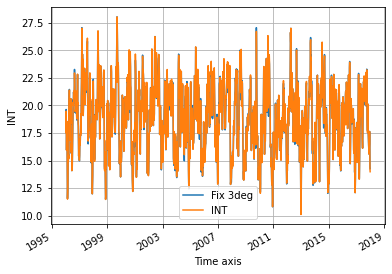

In [24]:
ds_JRA.T_2.mean('lon').plot(label='Fix 3deg')
ds_JRA.INT.mean('lon').plot(label='INT')
plt.grid()
plt.legend()

## Plot climatology

In [25]:
ds_JRA

<xarray.Dataset>
Dimensions:       (lon: 40, time_counter: 1606)
Coordinates:
  * lon           (lon) float32 -23.98 -23.92 -23.88 ... -22.12 -22.08 -22.02
  * time_counter  (time_counter) datetime64[ns] 1997-01-03T12:00:00 ... 2018-...
Data variables:
    Y_CM          (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    Z_CM          (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    INT           (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    INT_2p5       (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    INT_3         (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    INT_4         (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    T_30          (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    T_2           (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    T_2p5         (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    T_3           (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
Attributes:
    title:      EUC transports in INALT20 JRA
    timeStamp:  2021-05-28 18:52:22.539027
    history:    Original model output modified using INALT20_EUC_calc_transpo...

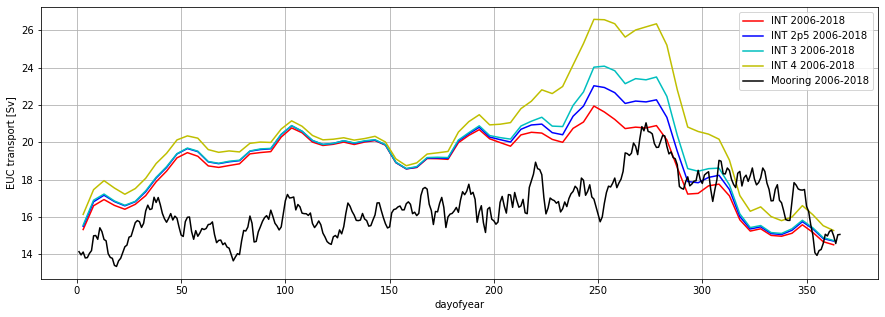

In [26]:
tlim_min,tlim_max = '2006','2018'
with xr.set_options(keep_attrs=True):
    JRA_cyc = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).groupby('time_counter.dayofyear').mean(dim=['time_counter','lon'])
    moor_cyc = moor.sel(time=slice(tlim_min,tlim_max)).groupby('time.dayofyear').mean(dim='time')
JRA_cyc.INT.plot.line('r',label='INT 2006-2018',size=5,aspect=3)
JRA_cyc.INT_2p5.plot.line('b',label='INT 2p5 2006-2018')
JRA_cyc.INT_3.plot.line('c',label='INT 3 2006-2018')
JRA_cyc.INT_4.plot.line('y',label='INT 4 2006-2018')
# JRA_cyc.T_2.plot.line('b',label='Fix 2 2006-2018')
# JRA_cyc.T_2p5.plot.line('c',label='Fix 2.5 2006-2018')
# JRA_cyc.T_3.plot.line('y',label='Fix 3 2006-2018')
# JRA_cyc.T_30.plot.line('g',label='T_30 2006-2018')
# JRA_cyc.T_0.plot.line('--k',label='T_0 2006-2018')
moor_cyc.plot.line('k',label='Mooring 2006-2018')

# tlim_min,tlim_max = '1997','2009'
# with xr.set_options(keep_attrs=True):
#     JRA_cyc = ds_JRA.sel(time_counter=slice(tlim_min,tlim_max)).groupby('time_counter.dayofyear').mean(dim=['time_counter','lon'])
# JRA_cyc.INT.plot.line('--r',label='INT 1997-2009')
# JRA_cyc.T_2.plot.line('--b',label='Fix 1997-2009')

plt.grid()
plt.legend()

In [29]:
ds_JRA

<xarray.Dataset>
Dimensions:       (lon: 40, time_counter: 1606)
Coordinates:
  * lon           (lon) float32 -23.98 -23.92 -23.88 ... -22.12 -22.08 -22.02
  * time_counter  (time_counter) datetime64[ns] 1997-01-03T12:00:00 ... 2018-...
Data variables:
    Y_CM          (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    Z_CM          (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    INT           (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    INT_2p5       (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    INT_3         (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    INT_4         (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    T_30          (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    T_2           (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    T_2p5         (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
    T_3           (lon, time_counter) float64 dask.array<chunksize=(40, 73), meta=np.ndarray>
Attributes:
    title:      EUC transports in INALT20 JRA
    timeStamp:  2021-05-28 18:52:22.539027
    history:    Original model output modified using INALT20_EUC_calc_transpo...

In [34]:
 EUC_JRA_AH_SAH_CYC,EUC_JRA_SAH_CYC,EUC_JRA_AH_CYC = calc_AH_SAH_model(
        ds_JRA.INT_3.mean('lon').sel(time_counter=slice(tlim_min,tlim_max)),JRA_cyc)

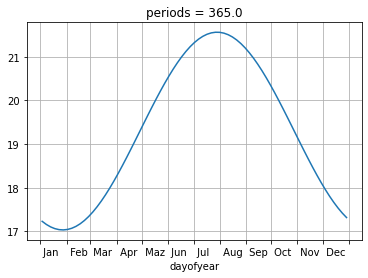

In [66]:
fig,ax = plt.subplots(1,1)
EUC_JRA_AH_CYC.plot(ax=ax,
    xticks=np.cumsum([1,31,28,31,30,31,30,31,31,30,31,30,31]))
ax.set_xticklabels((' Jan',' Feb',' Mar',' Apr',' Maz',' Jun',' Jul',
                    ' Aug',' Sep',' Oct',' Nov',' Dec',''),ha='left')
ax.grid()

In [70]:
datetime.datetime.strptime(f'2022 {int(EUC_JRA_AH_CYC.idxmax().values)}', '%Y %j')

datetime.datetime(2022, 7, 27, 0, 0)